# HW07: Кластеризация, внутренние метрики качества, PCA/t-SNE

## Задание
Цель: Закрепить понимание различий между семействами методов кластеризации, навыки корректного препроцессинга для distance-based методов, оценку качества кластеризации без истинных меток.

In [1]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Установка стиля для графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Загрузка и анализ данных

In [2]:
# Загрузка датасетов
datasets = []
dataset_names = ['S07-hw-dataset-01', 'S07-hw-dataset-02', 'S07-hw-dataset-03']

for name in dataset_names:
    df = pd.read_csv(f'data/{name}.csv')
    datasets.append(df)
    print(f"Dataset {name} shape: {df.shape}")
    print(f"Dataset {name} info:")
    print(df.info())
    print(f"Dataset {name} description:")
    print(df.describe())
    print(f"Dataset {name} missing values:")
    print(df.isnull().sum())
    print("-" * 50)

Dataset S07-hw-dataset-01 shape: (12000, 9)
Dataset S07-hw-dataset-01 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None
Dataset S07-hw-dataset-01 description:
         sample_id           f01           f02           f03           f04  \
count  12000.00000  12000.000000  12000.000000  12000.000000  12000.000000   
mean    5999.50000     -2.424716     19.107804     -0.222063     -8.284501   
std     3464.24595     11.014315     60.790338

## Препроцессинг данных

In [3]:
# Функция для препроцессинга каждого датасета
def preprocess_dataset(df):
    # Сохраняем sample_id отдельно
    sample_ids = df['sample_id'].copy()
    
    # Удаляем sample_id из признаков
    X = df.drop(columns=['sample_id'])
    
    # Определяем типы признаков
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")
    
    # Создаем препроцессор
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_features)
        ]
    )
    
    # Применяем препроцессинг
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed, sample_ids, preprocessor, numeric_features, categorical_features

# Обработка всех датасетов
processed_data = []
preprocessors = []

for i, df in enumerate(datasets):
    print(f"Processing dataset {i+1}: {dataset_names[i]}")
    X_proc, ids, prep, num_feats, cat_feats = preprocess_dataset(df)
    processed_data.append((X_proc, ids))
    preprocessors.append(prep)
    print(f"Processed shape: {X_proc.shape}")
    print("-" * 50)

Processing dataset 1: S07-hw-dataset-01
Numeric features: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
Categorical features: []
Processed shape: (12000, 8)
--------------------------------------------------
Processing dataset 2: S07-hw-dataset-02
Numeric features: ['x1', 'x2', 'z_noise']
Categorical features: []
Processed shape: (8000, 3)
--------------------------------------------------
Processing dataset 3: S07-hw-dataset-03
Numeric features: ['x1', 'x2', 'f_corr', 'f_noise']
Categorical features: []
Processed shape: (15000, 4)
--------------------------------------------------


## Кластеризация и оценка

In [4]:
# Функция для оценки кластеризации
def evaluate_clustering(X, labels):
    # Убираем точки с меткой -1 (шум для DBSCAN)
    mask = labels != -1
    X_filtered = X[mask]
    labels_filtered = labels[mask]
    
    if len(np.unique(labels_filtered)) < 2:
        return {'silhouette': -1, 'davies_bouldin': -1, 'calinski_harabasz': -1, 'noise_ratio': 1 - len(X_filtered)/len(X)}
    
    try:
        sil_score = silhouette_score(X_filtered, labels_filtered)
    except:
        sil_score = -1
    
    try:
        db_score = davies_bouldin_score(X_filtered, labels_filtered)
    except:
        db_score = -1
    
    try:
        ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
    except:
        ch_score = -1
    
    noise_ratio = 1 - len(X_filtered)/len(X)
    
    return {
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score,
        'noise_ratio': noise_ratio
    }

# Функция для кластеризации с подбором параметров
def cluster_and_evaluate(X, dataset_idx):
    results = {}
    
    # KMeans
    print(f"\nDataset {dataset_idx+1}: KMeans")
    k_range = range(2, 21)
    kmeans_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        scores = evaluate_clustering(X, labels)
        kmeans_scores.append(scores)
    
    # Находим оптимальное k по silhouette
    sil_scores = [score['silhouette'] for score in kmeans_scores]
    best_k_idx = np.argmax(sil_scores)
    best_k = k_range[best_k_idx]
    
    # Обучаем KMeans с лучшим k
    kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    kmeans_labels = kmeans_best.fit_predict(X)
    
    results['kmeans'] = {
        'labels': kmeans_labels,
        'params': {'n_clusters': best_k},
        'scores': evaluate_clustering(X, kmeans_labels),
        'silhouette_by_k': sil_scores
    }
    
    # DBSCAN
    print(f"Dataset {dataset_idx+1}: DBSCAN")
    eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    min_samples_values = [2, 3, 4, 5, 6, 7, 8]
    
    dbscan_results = []
    param_combinations = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X)
                scores = evaluate_clustering(X, labels)
                dbscan_results.append(scores)
                param_combinations.append({'eps': eps, 'min_samples': min_samples})
            except:
                continue
    
    # Находим лучшую комбинацию параметров
    if dbscan_results:
        sil_scores_dbscan = [score['silhouette'] for score in dbscan_results]
        best_dbscan_idx = np.argmax(sil_scores_dbscan)
        best_dbscan_params = param_combinations[best_dbscan_idx]
        
        dbscan_best = DBSCAN(**best_dbscan_params)
        dbscan_labels = dbscan_best.fit_predict(X)
        
        results['dbscan'] = {
            'labels': dbscan_labels,
            'params': best_dbscan_params,
            'scores': evaluate_clustering(X, dbscan_labels)
        }
    else:
        results['dbscan'] = None
    
    # Agglomerative Clustering
    print(f"Dataset {dataset_idx+1}: Agglomerative Clustering")
    linkages = ['ward', 'complete', 'average', 'single']
    agg_results = {}
    
    for linkage in linkages:
        agg_scores = []
        for k in k_range:
            try:
                if linkage == 'ward':
                    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
                else:
                    # Для других linkage нужно использовать евклидово расстояние
                    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric='euclidean')
                labels = agg.fit_predict(X)
                scores = evaluate_clustering(X, labels)
                agg_scores.append(scores)
            except:
                agg_scores.append({'silhouette': -1, 'davies_bouldin': -1, 'calinski_harabasz': -1, 'noise_ratio': 1})
        
        agg_results[linkage] = {
            'silhouette_by_k': [score['silhouette'] for score in agg_scores],
            'scores_by_k': agg_scores
        }
    
    # Выбираем лучший linkage по максимальному silhouette
    best_linkage = max(linkages, key=lambda l: max(agg_results[l]['silhouette_by_k']))
    best_agg_k_idx = np.argmax(agg_results[best_linkage]['silhouette_by_k'])
    best_agg_k = k_range[best_agg_k_idx]
    
    agg_best = AgglomerativeClustering(n_clusters=best_agg_k, linkage=best_linkage)
    agg_labels = agg_best.fit_predict(X)
    
    results['agglomerative'] = {
        'labels': agg_labels,
        'params': {'n_clusters': best_agg_k, 'linkage': best_linkage},
        'scores': evaluate_clustering(X, agg_labels),
        'results_by_linkage': agg_results
    }
    
    return results

In [5]:
# Кластеризация для каждого датасета
all_results = []

for i, (X, sample_ids) in enumerate(processed_data):
    print(f"\nProcessing Dataset {i+1}: {dataset_names[i]}")
    results = cluster_and_evaluate(X, i)
    all_results.append(results)
    print(f"Completed Dataset {i+1}")


Processing Dataset 1: S07-hw-dataset-01

Dataset 1: KMeans
Dataset 1: DBSCAN
Dataset 1: Agglomerative Clustering
Completed Dataset 1

Processing Dataset 2: S07-hw-dataset-02

Dataset 2: KMeans
Dataset 2: DBSCAN
Dataset 2: Agglomerative Clustering
Completed Dataset 2

Processing Dataset 3: S07-hw-dataset-03

Dataset 3: KMeans
Dataset 3: DBSCAN
Dataset 3: Agglomerative Clustering
Completed Dataset 3


## Визуализация

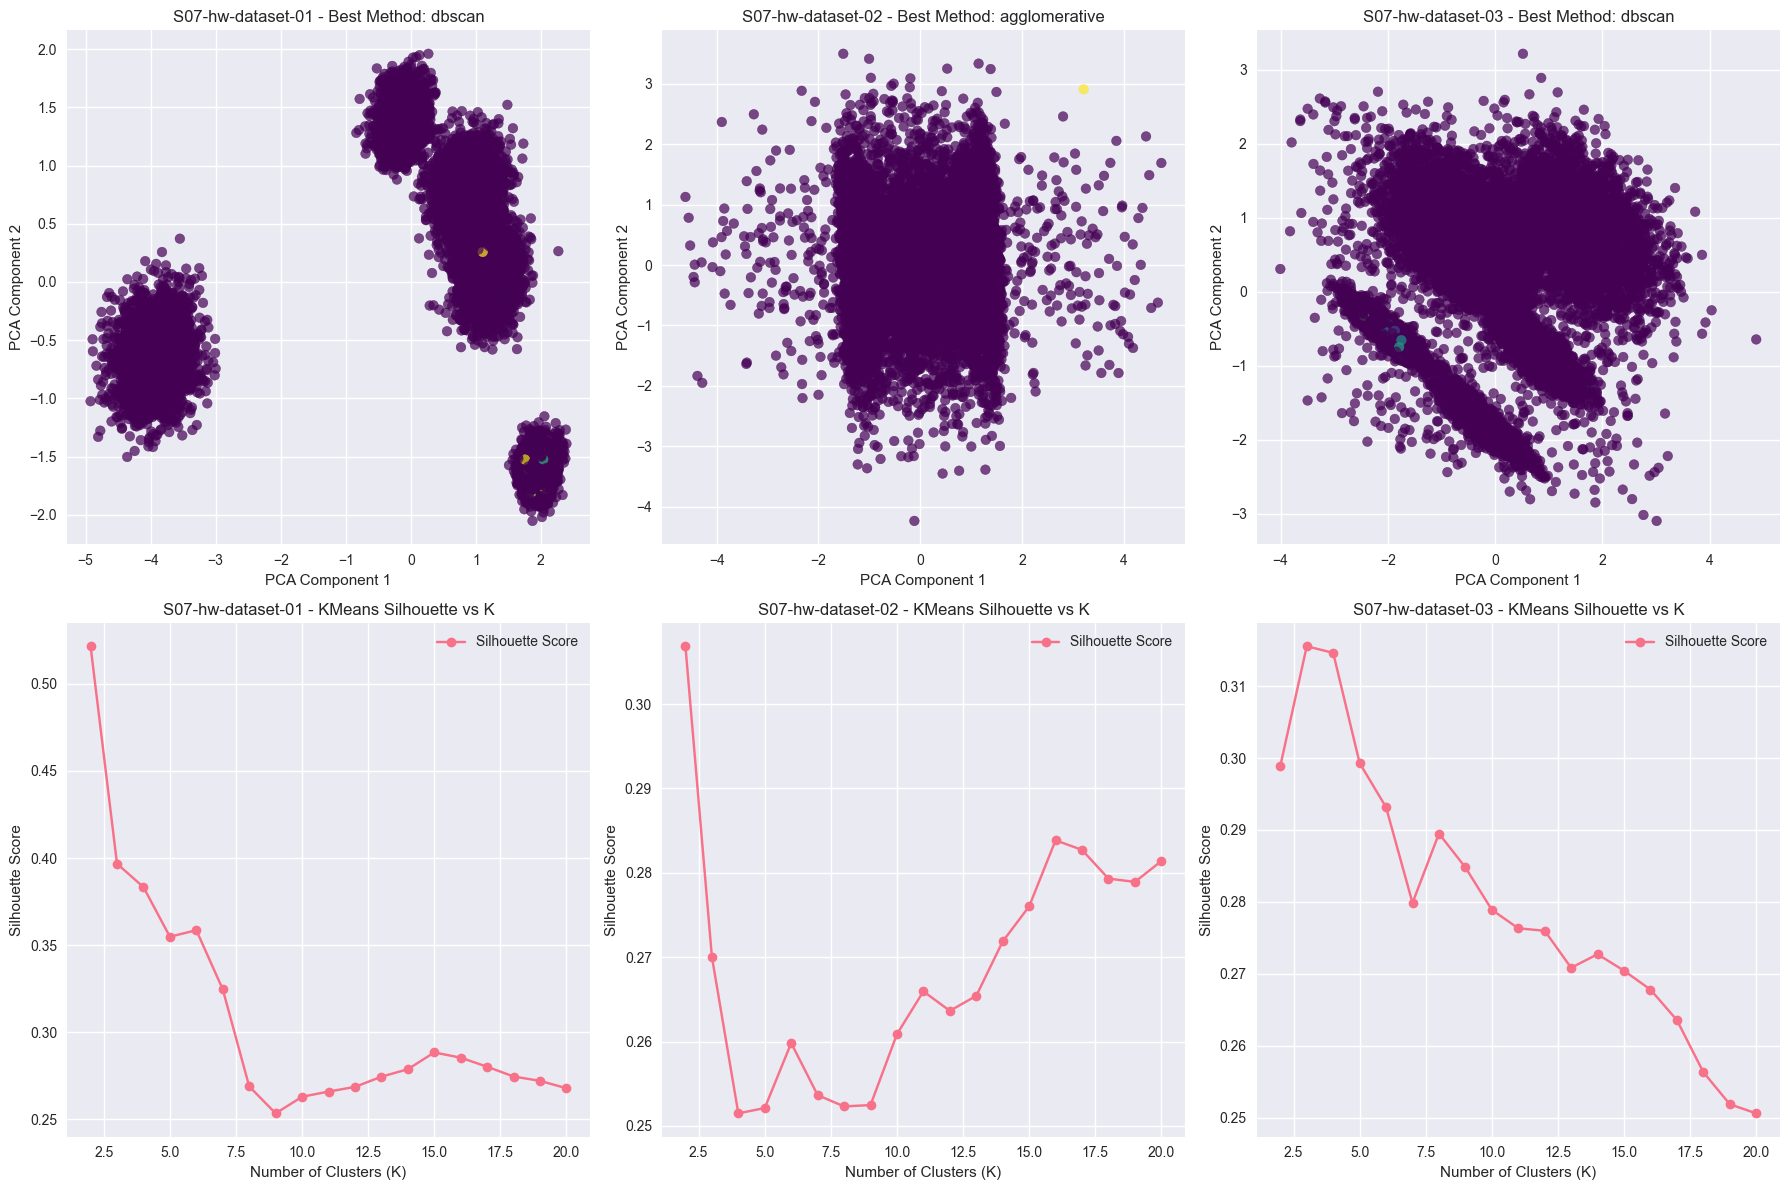

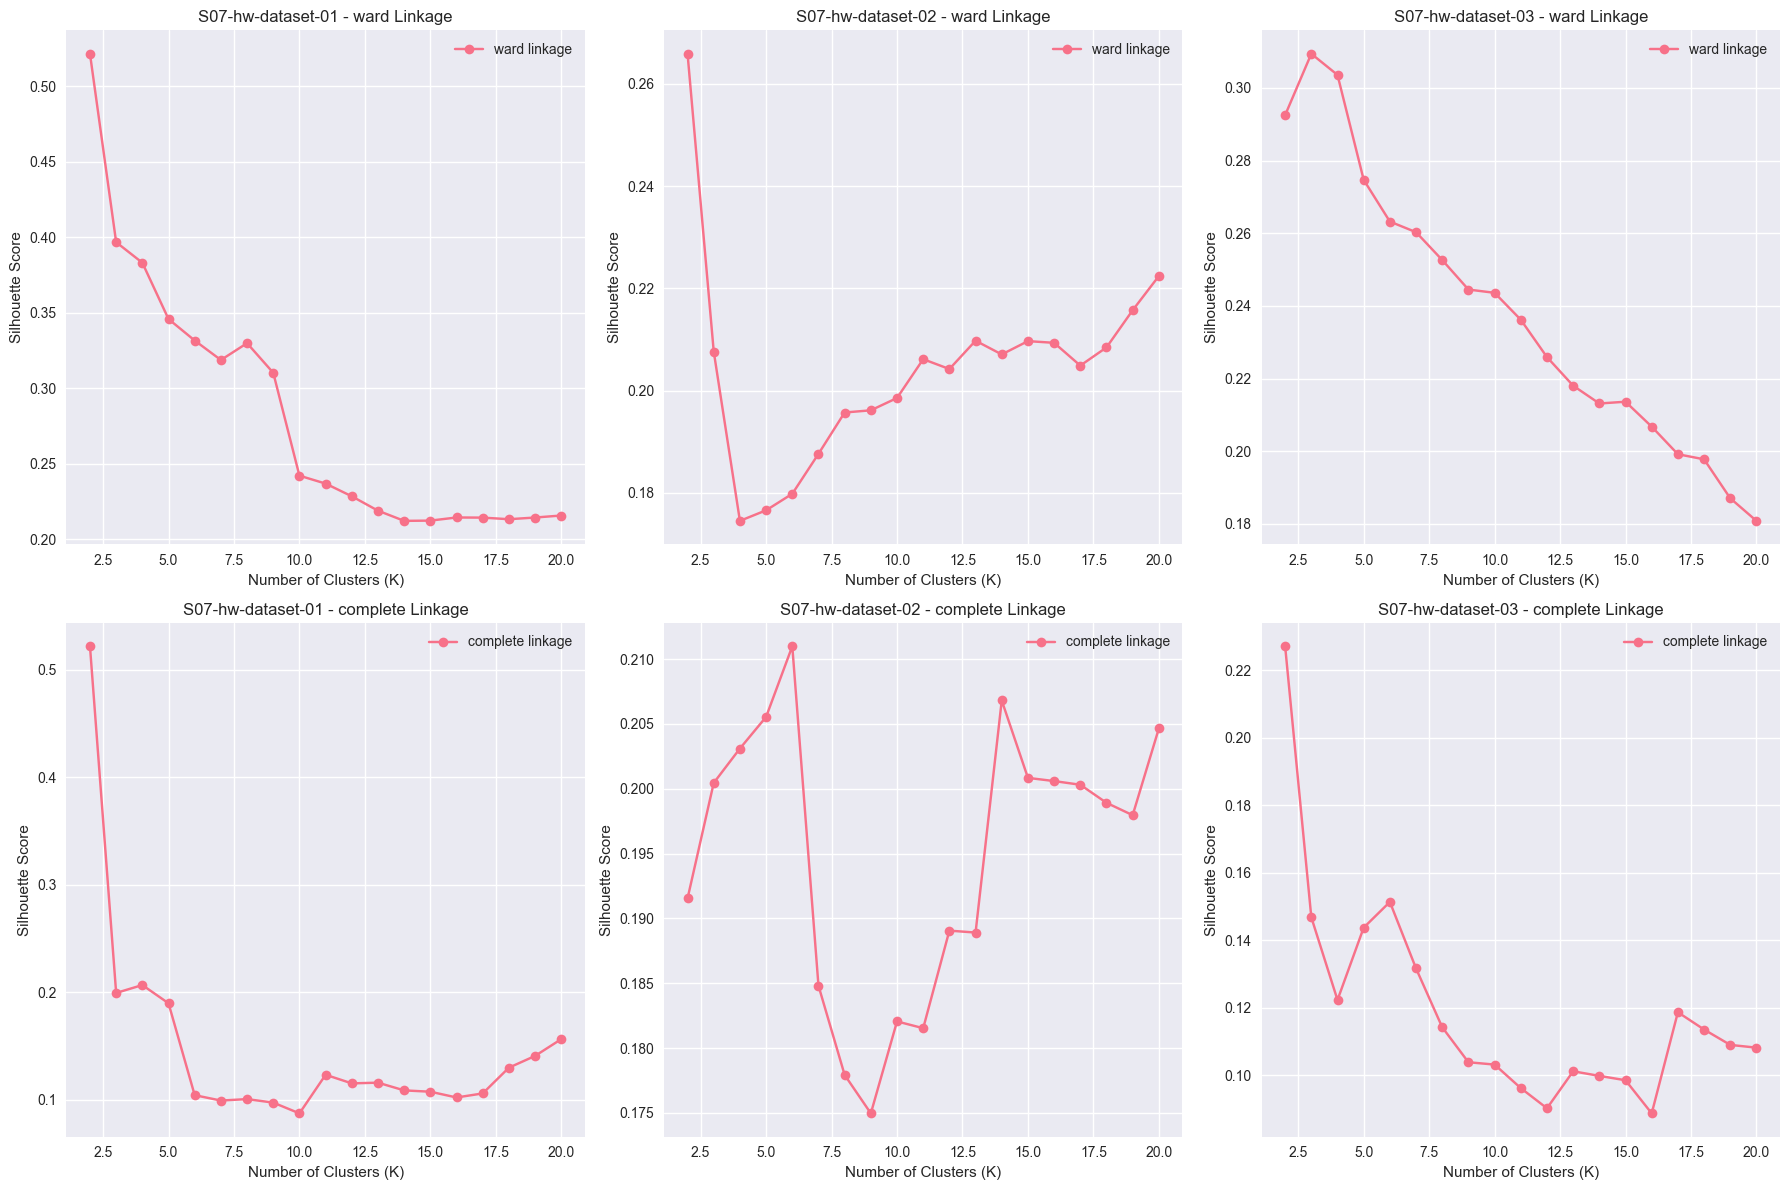

In [7]:
# Функция для создания визуализаций
def create_visualizations(all_results, processed_data, dataset_names):
    # Создаем PCA визуализации для лучшего результата каждого датасета
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, (results, (X, _)) in enumerate(zip(all_results, processed_data)):
        # PCA для лучшего результата
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X)
        
        # Определяем лучший метод по silhouette
        best_method = max(['kmeans', 'dbscan', 'agglomerative'], 
                         key=lambda m: results[m]['scores']['silhouette'] if results[m] and results[m]['scores']['silhouette'] != -1 else -2)
        
        best_labels = results[best_method]['labels']
        
        # График PCA с кластерами
        scatter = axes[0, i].scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.7)
        axes[0, i].set_title(f'{dataset_names[i]} - Best Method: {best_method}')
        axes[0, i].set_xlabel('PCA Component 1')
        axes[0, i].set_ylabel('PCA Component 2')
        
        # Подбор параметров для KMeans (silhouette vs k)
        k_range = range(2, 21)
        axes[1, i].plot(k_range, results['kmeans']['silhouette_by_k'], marker='o', label='Silhouette Score')
        axes[1, i].set_title(f'{dataset_names[i]} - KMeans Silhouette vs K')
        axes[1, i].set_xlabel('Number of Clusters (K)')
        axes[1, i].set_ylabel('Silhouette Score')
        axes[1, i].grid(True)
        axes[1, i].legend()
    
    plt.tight_layout()
    plt.savefig('artifacts/figures/pca_and_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Визуализация для Agglomerative Clustering по разным linkage
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, results in enumerate(all_results):
        agg_results = results['agglomerative']['results_by_linkage']
        k_range = range(2, 21)
        
        for j, linkage in enumerate(['ward', 'complete']):
            ax = axes[j, i]
            ax.plot(k_range, agg_results[linkage]['silhouette_by_k'], marker='o', label=f'{linkage} linkage')
            ax.set_title(f'{dataset_names[i]} - {linkage} Linkage')
            ax.set_xlabel('Number of Clusters (K)')
            ax.set_ylabel('Silhouette Score')
            ax.grid(True)
            ax.legend()
    
    plt.tight_layout()
    plt.savefig('artifacts/figures/agglomerative_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Создаем визуализации
create_visualizations(all_results, processed_data, dataset_names)

## Проверка устойчивости (на одном датасете)

In [8]:
# Проверка устойчивости для KMeans на первом датасете
def stability_check(X, n_runs=5):
    all_labels = []
    
    # Определяем оптимальное количество кластеров
    k_range = range(2, 11)
    best_k = 2  # Начальное значение
    best_silhouette = -1
    
    for k in k_range:
        sil_scores = []
        for run in range(3):  # Для ускорения используем 3 прогона
            kmeans = KMeans(n_clusters=k, random_state=run, n_init=10)
            labels = kmeans.fit_predict(X)
            if len(np.unique(labels)) > 1:
                try:
                    sil = silhouette_score(X, labels)
                    sil_scores.append(sil)
                except:
                    sil_scores.append(-1)
            else:
                sil_scores.append(-1)
        
        avg_sil = np.mean([s for s in sil_scores if s != -1])
        if avg_sil > best_silhouette:
            best_silhouette = avg_sil
            best_k = k
    
    print(f"Best k for stability test: {best_k}")
    
    # Запускаем KMeans с разными random_state
    for run in range(n_runs):
        kmeans = KMeans(n_clusters=best_k, random_state=run*42, n_init=10)
        labels = kmeans.fit_predict(X)
        all_labels.append(labels)
    
    # Рассчитываем ARI между всеми парами
    n_pairs = 0
    total_ari = 0
    
    for i in range(len(all_labels)):
        for j in range(i+1, len(all_labels)):
            ari = adjusted_rand_score(all_labels[i], all_labels[j])
            total_ari += ari
            n_pairs += 1
    
    avg_ari = total_ari / n_pairs if n_pairs > 0 else 0
    print(f"Average ARI between runs: {avg_ari:.3f}")
    
    return avg_ari, all_labels

# Проверяем устойчивость на первом датасете
print("Stability Check for Dataset 1 (KMeans):")
stability_ari, stability_labels = stability_check(processed_data[0][0])

Stability Check for Dataset 1 (KMeans):
Best k for stability test: 2
Average ARI between runs: 1.000


## Сохранение артефактов

In [9]:
# Сохраняем метрики
metrics_summary = []
best_configs = []

for i, (results, (_, sample_ids)) in enumerate(zip(all_results, processed_data)):
    dataset_metrics = {
        'dataset': dataset_names[i],
        'kmeans': results['kmeans']['scores'],
        'dbscan': results['dbscan']['scores'] if results['dbscan'] else None,
        'agglomerative': results['agglomerative']['scores']
    }
    metrics_summary.append(dataset_metrics)
    
    # Сохраняем лучшие конфигурации
    # Определяем лучший метод по silhouette
    methods_scores = {}
    for method in ['kmeans', 'dbscan', 'agglomerative']:
        if results[method] and results[method]['scores']['silhouette'] != -1:
            methods_scores[method] = results[method]['scores']['silhouette']
    
    if methods_scores:
        best_method = max(methods_scores, key=methods_scores.get)
        best_config = {
            'dataset': dataset_names[i],
            'best_method': best_method,
            'best_params': results[best_method]['params'],
            'best_scores': results[best_method]['scores']
        }
        best_configs.append(best_config)
    
    # Сохраняем метки для лучшего решения
    if methods_scores:
        best_method = max(methods_scores, key=methods_scores.get)
        best_labels = results[best_method]['labels']
        
        labels_df = pd.DataFrame({
            'sample_id': sample_ids,
            'cluster_label': best_labels
        })
        labels_df.to_csv(f'artifacts/labels_hw07_ds{i+1}.csv', index=False)

# Сохраняем JSON файлы
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

print("Artifacts saved successfully!")

Artifacts saved successfully!


## Итоги по каждому датасету

In [10]:
for i, (results, _) in enumerate(zip(all_results, processed_data)):
    print(f"\nDataset {i+1} ({dataset_names[i]}):")
    
    # Определяем лучший метод
    methods_scores = {}
    for method in ['kmeans', 'dbscan', 'agglomerative']:
        if results[method] and results[method]['scores']['silhouette'] != -1:
            methods_scores[method] = results[method]['scores']
    
    if methods_scores:
        best_method = max(methods_scores, key=lambda m: methods_scores[m]['silhouette'])
        best_scores = methods_scores[best_method]
        
        print(f"  Лучший метод: {best_method}")
        print(f"  Silhouette Score: {best_scores['silhouette']:.3f}")
        print(f"  Davies-Bouldin Score: {best_scores['davies_bouldin']:.3f}")
        print(f"  Calinski-Harabasz Score: {best_scores['calinski_harabasz']:.3f}")
        print(f"  Доля шума: {best_scores['noise_ratio']:.3f}")
        
        # Краткий анализ
        print(f"  Анализ:")
        if best_method == 'kmeans':
            print(f"    - KMeans показал хорошие результаты, что говорит о наличии компактных кластеров")
        elif best_method == 'dbscan':
            print(f"    - DBSCAN справился лучше, возможно, данные имеют произвольную форму или содержат шум")
        elif best_method == 'agglomerative':
            print(f"    - Аггломеративная кластеризация подошла, что может говорить о иерархической структуре данных")
    else:
        print("  Не удалось получить корректные результаты для ни одного метода")


Dataset 1 (S07-hw-dataset-01):
  Лучший метод: dbscan
  Silhouette Score: 0.741
  Davies-Bouldin Score: 0.269
  Calinski-Harabasz Score: 1467.954
  Доля шума: 0.991
  Анализ:
    - DBSCAN справился лучше, возможно, данные имеют произвольную форму или содержат шум

Dataset 2 (S07-hw-dataset-02):
  Лучший метод: agglomerative
  Silhouette Score: 0.521
  Davies-Bouldin Score: 0.342
  Calinski-Harabasz Score: 7.184
  Доля шума: 0.000
  Анализ:
    - Аггломеративная кластеризация подошла, что может говорить о иерархической структуре данных

Dataset 3 (S07-hw-dataset-03):
  Лучший метод: dbscan
  Silhouette Score: 0.500
  Davies-Bouldin Score: 0.716
  Calinski-Harabasz Score: 1943.885
  Доля шума: 0.984
  Анализ:
    - DBSCAN справился лучше, возможно, данные имеют произвольную форму или содержат шум
